<a href="https://colab.research.google.com/github/hych0/CO2RRCatalystScreening/blob/main/Main_CO2RR_CatalystScreening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # Journal Review on “Machine-Learning-Augmented Chemisorption Model for CO2 Electroreduction Catalyst Screening <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)

----
<font size="-2"><a name="cite_note-1"></a>[[1]]() Xin, Hongliang, et al. “Machine-Learning-Augmented Chemisorption Model for CO2 Electroreduction Catalyst Screening.” The Journal of Physical Chemistry Letters, vol. 8, no. 18, 2015, pp. 3528–33, https://doi.org/10.1021/acs.jpclett.5b01660




------------
#**1. Mount Google Drive and Import Libraries**

In [ ]:
from pandas import read_csv, DataFrame                                          
from sklearn.model_selection import train_test_split                            
from tensorflow.keras import Sequential, optimizers                             
from tensorflow.keras.layers import Dense                                       
from tensorflow.keras.utils import normalize                                    
from tensorflow.keras.callbacks import EarlyStopping                            
import tensorflow as tf                                                         
import numpy as np                                                              
import matplotlib.pyplot as plt
import seaborn as sns   
import pandas as pd   
from sklearn import preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/CO2RR_data.csv'
df = pd.read_csv(path, header=0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


-------------------
#**2. Split Input and Output**

In [ ]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

print('X\n')
print(X)
print('----------------------------------------------------------------------')
print("y\n")
print(y)

X

     d_filling  d_center  d_width  d_skew  d_kurt    W   radius   rd    IE   \
0         0.97     -2.21     1.11    1.08    8.87  5.30    1.41  0.67  7.73   
1         0.97     -2.25     1.05    1.13   10.94  5.30    1.41  0.67  7.73   
2         0.98     -1.66     0.97    0.47    8.60  5.30    1.41  0.67  7.73   
3         0.98     -1.90     0.88    0.06   15.15  5.30    1.41  0.67  7.73   
4         0.97     -2.10     1.13    0.26    8.42  5.30    1.41  0.67  7.73   
..         ...       ...      ...     ...     ...   ...     ...   ...   ...   
293       0.88     -2.03     1.87    0.17    3.65  6.74    1.53  1.04  9.00   
294       0.89     -1.80     1.77    0.13    4.01  6.74    1.53  1.04  9.00   
295       0.89     -1.77     1.76   -0.30    7.25  6.74    1.53  1.04  9.00   
296       0.90     -1.81     1.69    0.02    5.88  6.74    1.53  1.04  9.00   
297       0.90     -1.91     1.73   -0.22    7.63  6.74    1.53  1.04  9.00   

      EA    PEN  LPEN  Vad2  
0    1.24  1.90  1

-----------
#**3. Preprocessing Data**

> Artificial Neuron

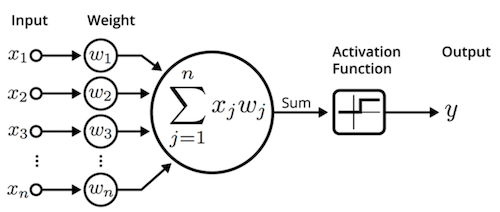

----------
> We transform the training data to make sure that the various features have similar value ranges (feature scaling) so that gradient descents can **converge faster** and the **weight values are not affected by scale**.  

> Two common methods of preprocessing data are standardization and normalization. 
-------

> 1. Normalization

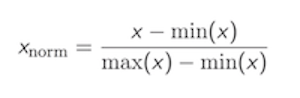
- Scaled [0.1] or [-1,1]
- Outliers can be affected




> 2. Standardization

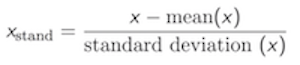
- Transformed using standard deviation
- Standardization does not get affected by outliers because there is no predefined range of transformed features.



------------------
> Split the data into training and test sets.

In [ ]:
from sklearn.model_selection import train_test_split                            
# split into train and test datasets                                            
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)       
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(238, 13) (60, 13) (238,) (60,)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

> **Data leakage** is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.

> Data leakage can often produce overly optimistic predictive models.





> To avoid **data leakage**, the scaler is fit to the training dataset, and training and test inputs are transformed.

In [ ]:
# fit on the training dataset
scaler.fit(X_train)

StandardScaler()

In [ ]:
# scale the training dataset
X_train = scaler.transform(X_train)
# scale the test dataset
X_test = scaler.transform(X_test)

Text(0.5, 1.0, 'Standardized')

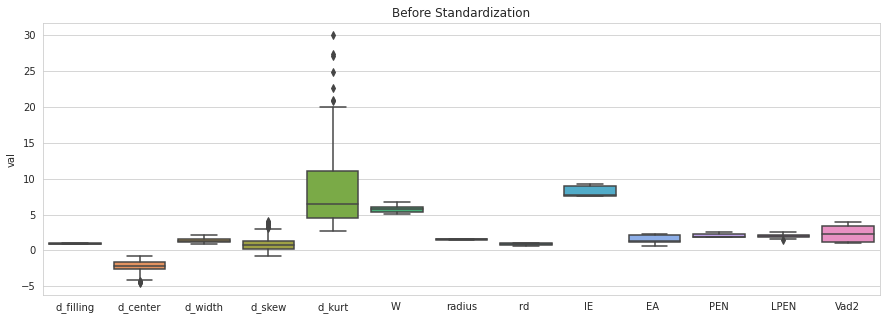

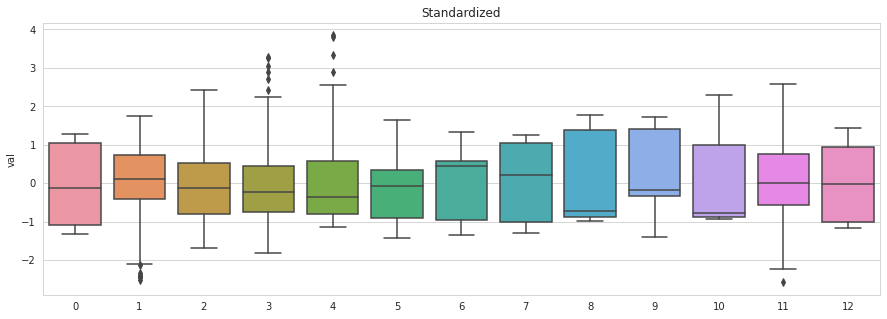

In [ ]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
fig = plt.ylabel('val')
fig = sns.boxplot(data=X)
fig.set_title('Before Standardization')

sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
fig = plt.ylabel('val')
fig = sns.boxplot(data=X_train)
fig.set_title('Standardized')

------------
#**5. Build model**


-------
> Build Model

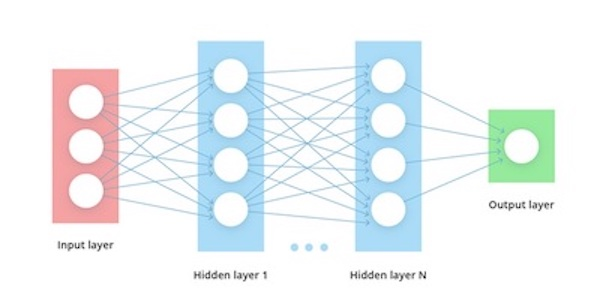

In [ ]:
# build model given a set of parameters
input_shape = X_train.shape[1]

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, optimizer='adam'):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="sigmoid"))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss="mse")
    return model

- Import Keras Wrapper to use scikit learn for Random Search Cross Validation

In [ ]:
import keras
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


> - Fit on data

> Early stopping means training until the validation error does not decrease for a specified number (patience) of iterations. 

In [ ]:
keras_reg.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), 
              callbacks=[keras.callbacks.EarlyStopping(patience=200)])
#mse_test = keras_reg.score(X_test, y_test)


Epoch 1/500
8/8 [==============================] - 1s 26ms/step - loss: 0.3219 - val_loss: 0.2332
Epoch 2/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2241 - val_loss: 0.1626
Epoch 3/500
8/8 [==============================] - 0s 5ms/step - loss: 0.1539 - val_loss: 0.1155
Epoch 4/500
8/8 [==============================] - 0s 5ms/step - loss: 0.1091 - val_loss: 0.0851
Epoch 5/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0807 - val_loss: 0.0640
Epoch 6/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0638 - val_loss: 0.0497
Epoch 7/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0524 - val_loss: 0.0404
Epoch 8/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0462 - val_loss: 0.0356
Epoch 9/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0421 - val_loss: 0.0313
Epoch 10/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0397 - val_loss: 0.0283
Epoch 11/500
8/8 [==========

#**6. Tune Hyperparameters using RandomSearchCrossValidation**

> Main methods for tuning hyperparameters
- Grid Search: 
  - Define a search space as a grid of hyperparameter values and evaluate **every position** in the grid.
  - Great for spot-checking combinations that are known to perform well generally. 
- Random Search: 
  - Define a search space as a bounded domain of hyperparameter values and **randomly sample** points in that domain.
  - Generally more likely to find optimal than grid search.
- Bayesian Optimization
  - A sequential model-based optimization (SMBO) algorithm that uses the results **from the previous iteration** to decide the next hyperparameter value candidates.


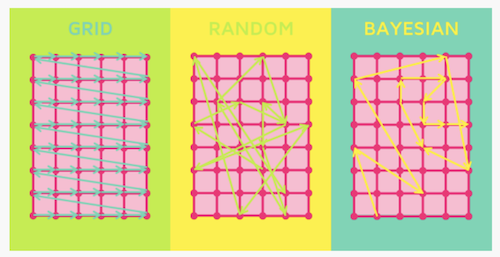

> **RamdomizedSearchCV**
- Similar to RandomSearch, where parameters are randomly selected.
- 'n_iter': Number of random combinations.
- 'cv': Number of tests. 
  - if cv = 5, data is split into 5 parts, where 4 are for training and 1 is for testing
- Total number of fitting (testing) = 'n_iter' * 'cv'

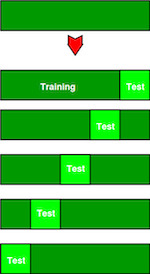

> Hyperparameters to be tuned:
 
*   Optimizer = {adam, adadelta, adamax, RMSprop, SGD,...}
*   Learning_rate = {10^-1, 10^-2, 10^-3, 10^-4,...}
*   \# of layers = {1, 2, 3, 4, 5, ...}
*   \# of units in layer 1 = {1 ~ 100}
*   \# of units in layer 2 = {1 ~ 100}
*   \# of units in layer 3 = {1 ~ 100}

> Set Hyperparameters:

* l2_lambda = 0.001
* patience=200
* epochs=500
* batch_size=32 # 2^N form is preferred.
* kernel_regularizer=None
* Activation function = 'sigmoid'

In [ ]:
# use RandomSearchCV

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": np.arange(1e-4, 1e-1).tolist(),
    'optimizer':['adam','rmsprop','adadelta', 'adamax', 'RMSprop', 'SGD']
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=500)


Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 4ms/step - loss: 0.2255
Epoch 4/500
5/5 [==============================] - 0s 3ms/step - loss: 0.1684
Epoch 5/500
5/5 [==============================] - 0s 4ms/step - loss: 0.1372
Epoch 6/500
5/5 [==============================] - 0s 3ms/step - loss: 0.1124
Epoch 7/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0863
Epoch 8/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0665
Epoch 9/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0565
Epoch 10/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0503
Epoch 11/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0468
Epoch 12/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0442
Epoch 13/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0423
Epoch 14/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0412
Epoch 15/500
5/5 [==

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd3297f8890>,
                   param_distributions={'learning_rate': [0.0001],
                                        'n_hidden': [1, 2, 3],
                                        'n_neurons': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'optimizer': ['adam', 'rmsprop',
                                                      'adadelta', 'adamax',
                                                      'RMSprop', 'SGD']})

In [ ]:
best_params=rnd_search_cv.best_params_

print("Best Parameters:\n")
print(best_params)


Best Parameters:

{'optimizer': 'adam', 'n_neurons': 70, 'n_hidden': 3, 'learning_rate': 0.0001}


#**7. Model Evaluation using KFold**

------
> Model Validation Step
- Ensures that the model is generalized i.e, performs well on the unseen data

-------
1. **Hold out validation**
> Separate initial dataset into two parts – training data and testing data. Then, we train the model on the training data and then see the performance on the unseen data.


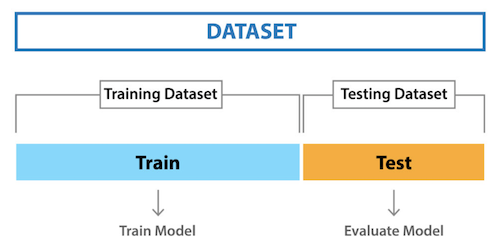

Pros
>- Fully independent of the data.
- Only needs to be run once so has lower computational costs.

Cons
>- The performance leads to a higher variance if we have a dataset of smaller size.

--------
2. **k-fold Cross Validation**
> Randomly divide your entire dataset into k numbers of folds.
For each fold in your dataset, build your model on k – 1 folds of the dataset and test the model to find the performance for the kth fold.
Repeat this until each of the k-folds has become the test set exactly once.
Finally, the average of your k  accuracies is called the cross-validation accuracy and it will serve as our performance metric for the model.

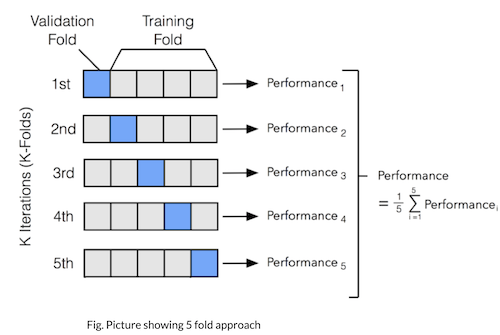

Pros
> - Not affected much by outliers.
- Less biased model.
- The best approach for limited amount of input data.

Cons
> - Requires computation k times as much as to evaluate since training algorithm has to be rerun from start K times to complete the k folds.

> Before finalizing the model, evaluate the model with KFold.

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop


# hyperparameters not to be optimized
l2_lambda = 0.001
patience=200
epochs=500
batch_size=32 # 2^N form is preferred.
kernel_regularizer=None
activation='sigmoid' 
verbosity = 1

# Optimized units from RamdomizedSearchCV
unit_1 = 70
unit_2 = 70
unit_3 = 70

# Optimized optimizer and learning rate from RandomizedSearchCV
optimizer = Adam(learning_rate=0.0001)



In [ ]:
# 10fold
num_folds = 10

# epochs
no_epochs = 500

# Define per-fold score containers 
acc_per_fold = []
loss_per_fold = []
loss_function = 'MSE'
fold_no = 1

n_features = X.shape[1]
kfold = KFold(n_splits=num_folds, shuffle=True)

for train, test in kfold.split(X_train, y_train):
    model2 = Sequential()
    model2.add(Dense(units=unit_1, activation=activation, kernel_initializer='he_normal',
                kernel_regularizer=kernel_regularizer,                       
                input_shape=(n_features,)))                                                                                                  
    model2.add(Dense(units=unit_2, activation=activation, kernel_initializer='he_normal',
                    kernel_regularizer=kernel_regularizer))
    model2.add(Dense(units=unit_3, activation=activation, kernel_initializer='he_normal',
                    kernel_regularizer=kernel_regularizer))
    model2.add(Dense(1))     
    model2.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['MAE'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model2.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity)

    # Generate generalization metrics
    scores = model2.evaluate(X_train, y_train, verbose=0)
    print(f'Score for fold {fold_no}: {model2.metrics_names[0]} of {scores[0]}; {model2.metrics_names[1]} of {scores[1]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1



Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 0s 3ms/step - loss: 0.2502 - MAE: 0.4236
Epoch 8/500
8/8 [==============================] - 0s 4ms/step - loss: 0.2431 - MAE: 0.4188
Epoch 9/500
8/8 [==============================] - 0s 3ms/step - loss: 0.2307 - MAE: 0.4113
Epoch 10/500
8/8 [==============================] - 0s 3ms/step - loss: 0.2224 - MAE: 0.4054
Epoch 11/500
8/8 [==============================] - 0s 3ms/step - loss: 0.2157 - MAE: 0.3997
Epoch 12/500
8/8 [==============================] - 0s 3ms/step - loss: 0.2106 - MAE: 0.3953
Epoch 13/500
8/8 [==============================] - 0s 3ms/step - loss: 0.2054 - MAE: 0.3905
Epoch 14/500
8/8 [==============================] - 0s 3ms/step - loss: 0.2004 - MAE: 0.3857
Epoch 15/500
8/8 [==============================] - 0s 3ms/step - loss: 0.1957 - MAE: 0.3811
Epoch 16/500
8/8 [==============================] - 0s 3ms/step - loss: 0.1910 - MAE: 0.3767
Epoch 17/500
8/8 [================

> Average MSE for all folds

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Mean Squared Error: {loss_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average MSE for all folds:')
#print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Mean Squared Error: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Mean Squared Error: 0.013919341377913952
------------------------------------------------------------------------
> Fold 2 - Mean Squared Error: 0.01454128697514534
------------------------------------------------------------------------
> Fold 3 - Mean Squared Error: 0.012525542639195919
------------------------------------------------------------------------
> Fold 4 - Mean Squared Error: 0.013421463780105114
------------------------------------------------------------------------
> Fold 5 - Mean Squared Error: 0.013336136005818844
------------------------------------------------------------------------
> Fold 6 - Mean Squared Error: 0.015606144443154335
------------------------------------------------------------------------
> Fold 7 - Mean Squared Error: 0.013100559823215008
--------------------------------------

MSE_train (eV) =  0.01373


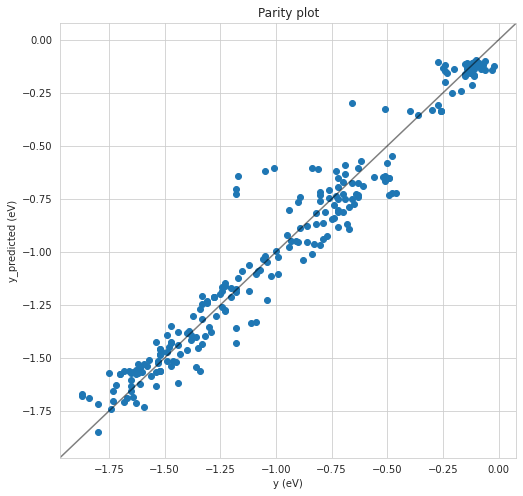

In [ ]:
# make a prediction & parity plot                                                       
fig = plt.figure(figsize=(18,8))                                                                                                                                                                                                                                             
yhat= model2.predict(X_train)                                                      
plt2 = fig.add_subplot(122)                                                 
plt2.set_title('Parity plot')                        
plt2.set_xlabel('y (eV)')                                                   
plt2.set_ylabel('y_predicted (eV)')                                         
x_lin = np.linspace(-10,10,10)
plt2.plot(x_lin, x_lin, c='k', alpha=0.5)     


plt2.scatter(y_train, yhat)                                                       
bottom, top = y.min()-0.1, y.max()+0.1
plt2.set_ylim(bottom, top)                                                  
plt2.set_xlim(bottom, top)
# fig.savefig(fig_path, dpi=300, format='png',)                               
# model.save('./trained_model.h5')   
fig.show()

print('MSE_train (eV) = {:8.5f}'
      .format(np.mean(loss_per_fold))) 


> Evaluating on the test set and comparing the results to the DFT values

Prediction on Test Data using 10-fold Cross Validation
MSE_Test (eV) =  0.00978, MAE_Test (ev) =  0.06446, RMSE_Test (eV) =  0.09891


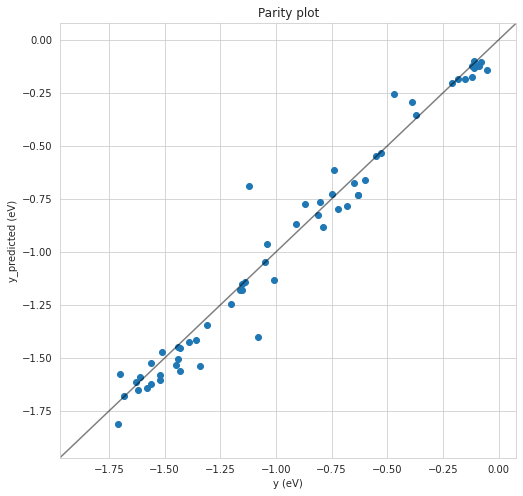

In [ ]:
# Prediction on Test Data 
# learning curve                                                       
fig = plt.figure(figsize=(18,8))                                               
                                                            
# make a prediction & parity plot
# Testing on a dataset that the model has not 'seen' before                                                        
yhat= model2.predict(X_test)                                                      
plt2 = fig.add_subplot(122)                                                 
plt2.set_title('Parity plot')                        
plt2.set_xlabel('y (eV)')                                                   
plt2.set_ylabel('y_predicted (eV)')                                         
x_lin = np.linspace(-10,10,10)
plt2.plot(x_lin, x_lin, c='k', alpha=0.5)     


plt2.scatter(y_test, yhat)                                                       
bottom, top = y.min()-0.1, y.max()+0.1
plt2.set_ylim(bottom, top)                                                  
plt2.set_xlim(bottom, top)
# fig.savefig(fig_path, dpi=300, format='png',)                               
# model.save('./trained_model.h5')   
fig.show()

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,yhat)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test,yhat)
RMSE = np.sqrt(mse)
print("Prediction on Test Data using 10-fold Cross Validation")
print('MSE_Test (eV) = {:8.5f}, MAE_Test (ev) = {:8.5f}, RMSE_Test (eV) = {:8.5f}'
      .format(mse, mae, RMSE))                                                  


> Comparing to the experimental value, there was about 17.5% improvement in RMSE.


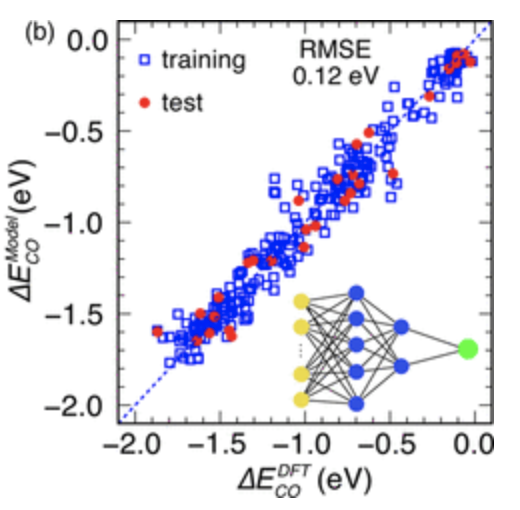